In [1]:
numeric_stats = ['derived_fg', 'derived_ft', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
fantasy_stats = ['derived_fg', 'derived_ft','TRB', 'AST', 'STL', 'BLK', 'TOV', '3P', 'PTS']
negative_stats = ['FTA', 'TOV', 'FGA']

In [2]:
# Import stats CSV
import pandas as pd

arr = pd.read_csv('current_season.csv')
arr['Player'] = arr['Player'].transform(lambda name: name.split('\\')[0].strip())
arr = arr.drop(['Rk', 'GS', 'Age', 'Pos', 'FG%', 'FT%', '2P%', 'eFG%', '3PA', '3P%', '2P', '2PA', 'Tm'], axis=1)
arr = arr.groupby(arr['Player']).sum()
arr['FT%'] = arr['FT'] * 100 / arr['FTA']
arr['FG%'] = arr['FG'] * 100 / arr['FGA']
arr['derived_fg'] = arr['FG'] * (arr['FG%'] - arr['FG%'].mean())
arr['derived_ft'] = arr['FT'] * (arr['FT%'] - arr['FT%'].mean())
arr[['TRB', 'AST', 'STL', 'BLK', 'TOV', '3P', 'PTS']] = arr[['TRB', 'AST', 'STL', 'BLK', 'TOV', '3P', 'PTS']].div(arr['G'], axis=0)

In [3]:
# Import average draft values TSV
raw_draft_values = pd.read_csv('draft_values.tsv', sep='\t')
raw_draft_values
def transform_name(name):
    notes_loc = name.find('Notes')
    if notes_loc > -1:
        name = name[notes_loc+5:]
    note_loc = name.find('Note')
    if note_loc > -1:
        name = name[note_loc+4:]
    return ' '.join(name.split()[0:2])

def transform_average(val):
    val = val[1:]
    try:
        num_val = float(val)
        return num_val
    except ValueError:
        return 0

raw_draft_values['Name'] = raw_draft_values['Name'].transform(transform_name)
raw_draft_values['Average'] = raw_draft_values['Average'].transform(transform_average)
raw_draft_values = raw_draft_values.set_index('Name')

In [4]:
arr = arr.join(raw_draft_values[['Average']])

In [5]:
transform_functions = {}
for col in arr.iteritems():
    stat = col[0]
    if stat in numeric_stats:
        std_dev = arr[stat].std()
        mean = arr[stat].mean()
        if stat in negative_stats:
            std_dev=std_dev*-1
        transform_functions[stat] = lambda val,mean=mean,std_dev=std_dev: (val-mean)*1000/std_dev
    else:
        transform_functions[stat] = lambda val: val
arr = arr.dropna()
z_scores = arr.transform(transform_functions)

In [6]:
z_scores['zach_points'] = z_scores[fantasy_stats].sum(axis=1)
z_scores = z_scores[z_scores.Average != 0]
z_scores['points_per_dollar'] = (z_scores['zach_points'])/z_scores['Average']
top_players = z_scores.nlargest(200, 'zach_points')[fantasy_stats+['zach_points', 'Average', 'points_per_dollar']]

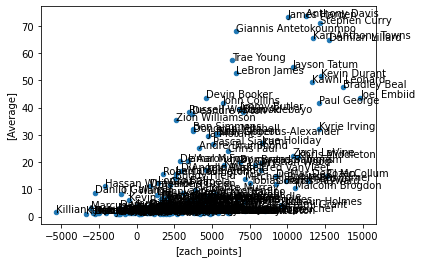

In [7]:
top_players['Name'] = top_players.index
ax = top_players.plot.scatter(x=['zach_points'], y=['Average'])
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

label_point(top_players.zach_points, top_players.Average, top_players.Name, ax)

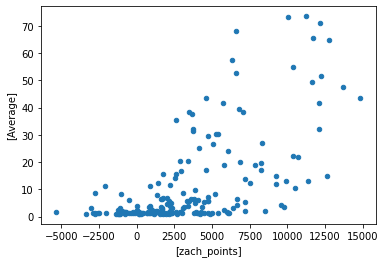

In [8]:
#Value of assists
#fantasy_stats = ['derived_fg', 'derived_ft','TRB', 'AST', 'STL', 'BLK', 'TOV', '3P', 'PTS']
top_players['asttov'] = top_players['AST'] - top_players['TOV']
ax = top_players.plot.scatter(x=['zach_points'], y=['Average'])
# def label_point(x, y, val, ax):
#     a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
#     for i, point in a.iterrows():
#         ax.text(point['x'], point['y'], str(point['val']))

# label_point(top_players.zach_points, top_players.asttov, top_players.Name, ax)

In [9]:
print(top_players.to_json(orient='index'))

{"Joel Embiid":{"derived_fg":2786.1820050404,"derived_ft":3735.0731257482,"TRB":3245.7993924046,"AST":584.6364103175,"STL":1545.1132013024,"BLK":2345.3062723708,"TOV":-2170.6667358708,"3P":190.8597055137,"PTS":2586.460634509,"zach_points":14848.7640113358,"Average":43.7,"points_per_dollar":339.788650145,"Name":"Joel Embiid","asttov":2755.3031461884},"Bradley Beal":{"derived_fg":2105.6727558929,"derived_ft":4339.6385386208,"TRB":654.321813632,"AST":1566.2586218055,"STL":1545.1132013024,"BLK":554.7321597978,"TOV":-2275.5759038076,"3P":1411.5733827151,"PTS":3788.2071181621,"zach_points":13689.9416881211,"Average":47.5,"points_per_dollar":288.2092986973,"Name":"Bradley Beal","asttov":3841.8345256132},"Damian Lillard":{"derived_fg":-29.5915780764,"derived_ft":5372.9649476871,"TRB":366.7648095704,"AST":2599.545160214,"STL":751.5097592917,"BLK":-295.3383784944,"TOV":-1674.7324874423,"3P":2946.7133101048,"PTS":2697.0265760499,"zach_points":12734.8621189047,"Average":64.9,"points_per_dollar":19